In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [52]:
#Imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

#### DATA VISUALIZATION


In [53]:
train_df=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_labels=train_df.iloc[:,0]
train_data=torch.reshape(torch.tensor((train_df.loc[:,train_df.columns!='label']).values),(len(train_labels),28,28)).unsqueeze(1)

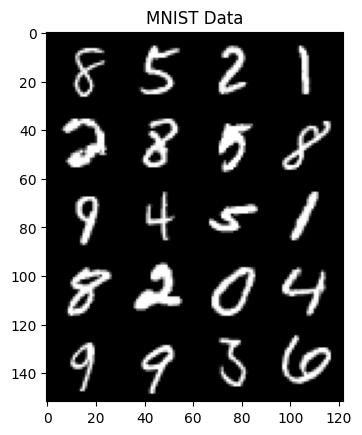

In [54]:
img_to_display=np.random.choice(train_data.shape[0],20)
img_to_display=train_data[img_to_display,:,:]
images=torchvision.utils.make_grid(img_to_display,nrow=4)
plt.imshow(images.numpy().transpose(1,2,0))
plt.title('MNIST Data')
plt.show()

In [55]:
class MNISTLoader(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images.iloc[idx].values  # Access values of the pandas series
        if self.labels is not None:
            label = self.labels.iloc[idx]

        if self.transform:
            return self.transform(image), label
        if self.labels is not None:
            return torch.reshape(torch.tensor(image), (1, 28, 28)), label
        return torch.reshape(torch.tensor(image), (1, 28, 28))

bs= 64
full_dataset = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_data, val_data = train_test_split(full_dataset, test_size=0.2, stratify=full_dataset["label"], random_state=42)

train_dataset = MNISTLoader(train_data.iloc[:, 1:], train_data["label"], None)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = MNISTLoader(val_data.iloc[:, 1:], val_data["label"], None)
val_loader = DataLoader(val_dataset, batch_size=bs)

test_dataset=MNISTLoader(pd.read_csv("/kaggle/input/digit-recognizer/test.csv"),None,None)
test_loader=DataLoader(test_dataset, batch_size=bs)

In [56]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1=nn.Sequential(nn.Conv2d(1,64,kernel_size=5,padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2,2)),
                                nn.Dropout(0.2)) # 64 x 14 x 14
        self.conv2=nn.Sequential(nn.Conv2d(64,128,kernel_size=5,padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2),
                                nn.Dropout(0.2)) # 128 x 7 x 7
        self.conv3=nn.Sequential(nn.Conv2d(128,256,kernel_size=5,padding=2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2),
                                nn.Dropout(0.2))  #256 x 3 x 3
        self.conv4=nn.Sequential(nn.Conv2d(256,512,kernel_size=5,padding=2),
                                 nn.ReLU(),
                                nn.Dropout(0.2))
        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(512*3*3,1024),nn.ReLU(),nn.Dropout(0.2))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(1024,256),nn.ReLU(),nn.Dropout(0.2))
        self.fc3=nn.Sequential(nn.Linear(256,10))
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        return F.log_softmax(x,dim=1)

In [57]:
from torch.optim import lr_scheduler as lr
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=Net()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
scheduler=lr.StepLR(optimizer=optimizer,step_size=1,gamma=0.9,last_epoch=-1)
criterion=nn.CrossEntropyLoss()

def val():
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in val_loader:
        data,target=data.to(device).to(torch.float),target.to(device)
        target=target.long()
        output = model(data)
        val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(val_loader.dataset)
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))  
def train(epochs):
    for epoch in range(0,epochs):
        model.train()
        for bs,(data,labels) in enumerate(train_loader):
            #print(data.size())
            data,labels=data.to(device).to(torch.float),labels.to(device)
            optimizer.zero_grad()
            output=model(data)
            labels=labels.long()
            loss=F.nll_loss(output,labels)
            #loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            if bs % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, bs * len(data), len(train_loader.dataset),
                100. * bs / len(train_loader), loss.item()))
        scheduler.step()  
        val()

      

In [58]:
epochs=20
train(epochs)

Train Epoch: 0 [0/33600 (0%)]	Loss: 2.719057
Train Epoch: 0 [6400/33600 (19%)]	Loss: 0.382441
Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.195743
Train Epoch: 0 [19200/33600 (57%)]	Loss: 0.236288
Train Epoch: 0 [25600/33600 (76%)]	Loss: 0.103424
Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.193901

Val set: Average loss: 0.0946, Accuracy: 8179/8400 (97%)

Train Epoch: 1 [0/33600 (0%)]	Loss: 0.255926
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.010783
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.056612
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.182288
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.112843
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.047990

Val set: Average loss: 0.0736, Accuracy: 8215/8400 (98%)

Train Epoch: 2 [0/33600 (0%)]	Loss: 0.165204
Train Epoch: 2 [6400/33600 (19%)]	Loss: 0.168736
Train Epoch: 2 [12800/33600 (38%)]	Loss: 0.028446
Train Epoch: 2 [19200/33600 (57%)]	Loss: 0.209288
Train Epoch: 2 [25600/33600 (76%)]	Loss: 0.069751
Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.093721


In [60]:
submission_rows = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1

    for X in test_loader:
        X = (X.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(device)
        preds = model(X).argmax(1)

        for pred in preds:
            submission_rows.append([image_id, pred.item()])
            image_id += 1

submission = pd.DataFrame(submission_rows)
submission.columns = submission.iloc[0]
submission = submission.drop(0, axis=0)

submission.to_csv('submission.csv', index=False)

In [ ]:
test()